# Decision trees and Random Forest with scikit-learn 📊📊

Let's train a decision tree and a random forest on our toy-dataset.

## What will you learn in this course? 🧐🧐
This lecture is a follow-along demo that will guide you through the steps of building logistic regressions models and evaluate them on actual data.

* Preprocessing
    * Training pipeline
    * Test pipeline
* Decision tree
    * Training with hyperparameter optimization
    * Performances
* Random forest
    * Training with hyperparameter optimization
    * Performances

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import  OneHotEncoder, StandardScaler, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, roc_curve
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) # to avoid deprecation warnings

import plotly.express as px
import plotly.graph_objects as go
import plotly.io as pio
# setting Jedha color palette as default
pio.templates["jedha"] = go.layout.Template(
    layout_colorway=["#4B9AC7", "#4BE8E0", "#9DD4F3", "#97FBF6", "#2A7FAF", "#23B1AB", "#0E3449", "#015955"]
)
pio.templates.default = "jedha"
pio.renderers.default = "svg" # to be replaced by "iframe" if working on JULIE

In [2]:
# Import dataset
print("Loading dataset...")
dataset = pd.read_csv("src/Data.csv")
print("...Done.")
print()

Loading dataset...
...Done.



In [3]:
# Basic stats
print("Number of rows : {}".format(dataset.shape[0]))
print()

print("Display of dataset: ")
display(dataset.head())
print()

print("Basics statistics: ")
data_desc = dataset.describe(include='all')
display(data_desc)
print()

print("Percentage of missing values: ")
display(100*dataset.isnull().sum()/dataset.shape[0])


Number of rows : 10

Display of dataset: 


,Country,Age,Salary,Purchased
0,France,44.0,72000,No
1,Spain,27.0,48000,Yes
2,Germany,30.0,54000,No
3,Spain,38.0,61000,No
4,Germany,40.0,69000,Yes



Basics statistics: 


,Country,Age,Salary,Purchased
count,10,9.000000,10.000000,10
unique,3,NaN,NaN,2
top,France,NaN,NaN,No
freq,4,NaN,NaN,5
mean,NaN,38.777778,64300.000000,NaN
std,NaN,7.693793,11681.419244,NaN
min,NaN,27.000000,48000.000000,NaN
25%,NaN,35.000000,55000.000000,NaN
50%,NaN,38.000000,64000.000000,NaN
75%,NaN,44.000000,71250.000000,NaN



Percentage of missing values: 


Country       0.0
Age          10.0
Salary        0.0
Purchased     0.0
dtype: float64

## Preprocessing
### Training pipeline

In [4]:
# Separate target variable Y from features X
print("Separating labels from features...")
features_list = ["Country", "Age", "Salary"]
target_variable = "Purchased"

X = dataset.loc[:,features_list]
Y = dataset.loc[:,target_variable]

print("...Done.")
print()

print('Y : ')
print(Y.head())
print()
print('X :')
print(X.head())

Separating labels from features...
...Done.

Y : 
0     No
1    Yes
2     No
3     No
4    Yes
Name: Purchased, dtype: object

X :
   Country   Age  Salary
0   France  44.0   72000
1    Spain  27.0   48000
2  Germany  30.0   54000
3    Spain  38.0   61000
4  Germany  40.0   69000


In [5]:
# Automatically detect positions of numeric/categorical features
idx = 0
numeric_features = []
numeric_indices = []
categorical_features = []
categorical_indices = []
for i,t in X.dtypes.iteritems():
    if ('float' in str(t)) or ('int' in str(t)) :
        numeric_features.append(i)
        numeric_indices.append(idx)
    else :
        categorical_features.append(i)
        categorical_indices.append(idx)

    idx = idx + 1

print('Found numeric features ', numeric_features,' at positions ', numeric_indices)
print('Found categorical features ', categorical_features,' at positions ', categorical_indices)

Found numeric features  ['Age', 'Salary']  at positions  [1, 2]
Found categorical features  ['Country']  at positions  [0]


In [6]:
# Divide dataset Train set & Test set 
print("Dividing into train and test sets...")
# WARNING : don't forget stratify=Y for classification problems
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=0, stratify = Y)
print("...Done.")
print()

Dividing into train and test sets...
...Done.



In [7]:
# Convert pandas DataFrames to numpy arrays before using scikit-learn
print("Convert pandas DataFrames to numpy arrays...")
X_train = X_train.values
X_test = X_test.values
Y_train = Y_train.tolist()
Y_test = Y_test.tolist()
print("...Done")

print(X_train[0:5,:])
print(X_test[0:2,:])
print()
print(Y_train[0:5])
print(Y_test[0:2])

Convert pandas DataFrames to numpy arrays...
...Done
[['France' 44.0 72000]
 ['Germany' 40.0 69000]
 ['Spain' nan 52000]
 ['France' 37.0 67000]
 ['Spain' 38.0 61000]]
[['Germany' 50.0 83000]
 ['France' 48.0 79000]]

['No', 'Yes', 'No', 'Yes', 'No']
['No', 'Yes']


### Training pipeline

In [8]:
# Missing values
print("Imputing missing values...")
print(X_train[0:5,:])
print()
imputer = SimpleImputer(strategy="mean")
X_train[:,numeric_indices] = imputer.fit_transform(X_train[:,numeric_indices])
print("...Done!")
print(X_train[0:5,:]) 
print() 

# Encoding categorical features and standardizing numerical features
print("Encoding categorical features and standardizing numerical features...")
print()
print(X_train[0:5,:])

# Normalization
numeric_transformer = StandardScaler()

# OHE / dummyfication
categorical_transformer = OneHotEncoder(drop='first')

featureencoder = ColumnTransformer(
    transformers=[
        ('cat', categorical_transformer, categorical_indices),    
        ('num', numeric_transformer, numeric_indices)
        ]
    )

X_train = featureencoder.fit_transform(X_train)
print("...Done")
print(X_train[0:5,:])

# Label encoding
print("Encoding labels...")
print(Y_train[0:5])
encoder = LabelEncoder()
Y_train = encoder.fit_transform(Y_train)
print("...Done")
print(Y_train[0:5])

Imputing missing values...
[['France' 44.0 72000]
 ['Germany' 40.0 69000]
 ['Spain' nan 52000]
 ['France' 37.0 67000]
 ['Spain' 38.0 61000]]

...Done!
[['France' 44.0 72000.0]
 ['Germany' 40.0 69000.0]
 ['Spain' 35.857142857142854 52000.0]
 ['France' 37.0 67000.0]
 ['Spain' 38.0 61000.0]]

Encoding categorical features and standardizing numerical features...

[['France' 44.0 72000.0]
 ['Germany' 40.0 69000.0]
 ['Spain' 35.857142857142854 52000.0]
 ['France' 37.0 67000.0]
 ['Spain' 38.0 61000.0]]
...Done
[[ 0.00000000e+00  0.00000000e+00  1.61706195e+00  1.46885753e+00]
 [ 1.00000000e+00  0.00000000e+00  8.22715727e-01  1.09777773e+00]
 [ 0.00000000e+00  1.00000000e+00 -1.41104234e-15 -1.00500778e+00]
 [ 0.00000000e+00  0.00000000e+00  2.26956063e-01  8.50391200e-01]
 [ 0.00000000e+00  1.00000000e+00  4.25542617e-01  1.08231607e-01]]
Encoding labels...
['No', 'Yes', 'No', 'Yes', 'No']
...Done
[0 1 0 1 0]


### Test pipeline

In [9]:
# Missing values
print("Imputing missing values...")
print(X_test[0:5,:])
X_test[:,numeric_indices] = imputer.transform(X_test[:,numeric_indices])
print("...Done!")
print(X_test[0:5,:]) 
print() 

# Encoding categorical features and standardizing numerical features
print("Encoding categorical features and standardizing numerical features...")
print(X_test[0:5,:])
X_test = featureencoder.transform(X_test)
print("...Done")
print(X_test[0:5,:])

# Label encoding
print("Encoding labels...")
print(Y_test[0:5])
Y_test = encoder.transform(Y_test)
print("...Done")
print(Y_test[0:5])

Imputing missing values...
[['Germany' 50.0 83000]
 ['France' 48.0 79000]]
...Done!
[['Germany' 50.0 83000.0]
 ['France' 48.0 79000.0]]

Encoding categorical features and standardizing numerical features...
[['Germany' 50.0 83000.0]
 ['France' 48.0 79000.0]]
...Done
[[1.         0.         2.80858127 2.82948345]
 [0.         0.         2.41140816 2.33471038]]
Encoding labels...
['No', 'Yes']
...Done
[0 1]


## Decision tree
Let's train a decision tree (with hyperparameter optimization) and evaluate its performances :

### Training with hyperparameter optimization
For Decision trees, the hyperparameters that are important for overfitting are :
* min_samples_leaf
* min_samples_split
* max_depth

In what follows, you'll see an example of how to tune these hyperparameters with cross-validated grid search :

In [10]:
# Perform grid search
print("Grid search...")
classifier = DecisionTreeClassifier()

# Grid of values to be tested
params = {
    'max_depth': [4, 6, 8, 10],
    'min_samples_leaf': [1, 2, 5],
    'min_samples_split': [2, 4, 8]
}
gridsearch = GridSearchCV(classifier, param_grid = params, cv = 3) # cv : the number of folds to be used for CV
gridsearch.fit(X_train, Y_train)
print("...Done.")
print("Best hyperparameters : ", gridsearch.best_params_)
print("Best validation accuracy : ", gridsearch.best_score_)

Grid search...
...Done.
Best hyperparameters :  {'max_depth': 4, 'min_samples_leaf': 2, 'min_samples_split': 4}
Best validation accuracy :  0.5


### Performances

In [11]:
# Predictions on training set
print("Predictions on training set...")
Y_train_pred = gridsearch.predict(X_train)
print("...Done.")
print(Y_train_pred)
print()

Predictions on training set...
...Done.
[1 1 0 1 0 1 1 1]



In [12]:
# Predictions on test set
print("Predictions on test set...")
Y_test_pred = gridsearch.predict(X_test)
print("...Done.")
print(Y_test_pred)
print()

Predictions on test set...
...Done.
[1 1]



In [13]:
# Print scores
print("accuracy on training set : ", accuracy_score(Y_train, Y_train_pred))
print("accuracy on test set : ", accuracy_score(Y_test, Y_test_pred))
print()

print("f1-score on training set : ", f1_score(Y_train, Y_train_pred))
print("f1-score on test set : ", f1_score(Y_test, Y_test_pred))
print()

accuracy on training set :  0.75
accuracy on test set :  0.5

f1-score on training set :  0.8
f1-score on test set :  0.6666666666666666



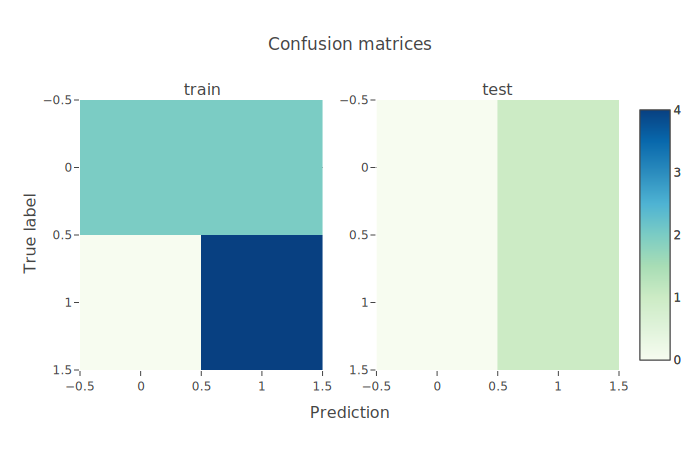

In [14]:
# Visualize confusion matrices
from plotly.subplots import make_subplots
cm_train = confusion_matrix(Y_train, Y_train_pred)
cm_test = confusion_matrix(Y_test, Y_test_pred)

fig = make_subplots(rows = 1, cols = 2, subplot_titles = ("train", "test"), 
                    x_title = 'Prediction', y_title = 'True label')
fig.update_layout(
        title = go.layout.Title(text = "Confusion matrices", x = 0.5))
fig.update_yaxes(autorange='reversed')
fig.add_trace(
    go.Heatmap(
        name = 'train',
        x = ['0', '1'], 
        y = ['0', '1'], 
        z = cm_train,
        colorscale = 'gnbu',
        zmin = 0,
        zmax = max(cm_train.max(), cm_test.max())
    ),
    row = 1,
    col = 1
)  
fig.add_trace(
    go.Heatmap(
        name = 'test',
        x = ['0', '1'], 
        y = ['0', '1'], 
        z = cm_test,
        colorscale = 'gnbu',
        zmin = 0,
        zmax = max(cm_train.max(), cm_test.max())
    ),
    row = 1,
    col = 2
)

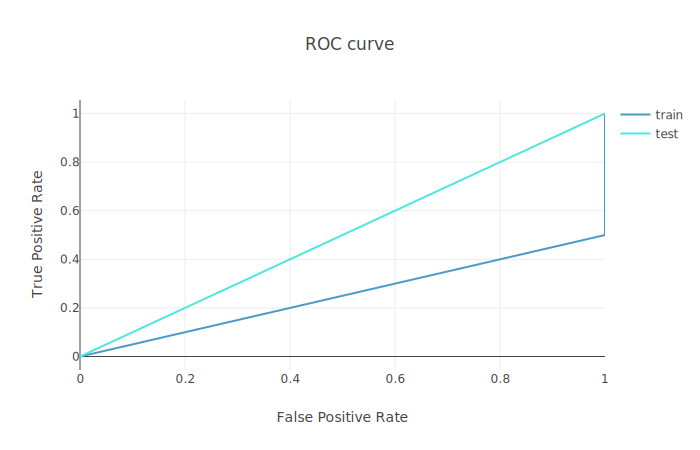

In [15]:
# Visualize ROC curves
probas_train = gridsearch.predict_proba(X_train)[:,1]
precisions, recalls, thresholds = roc_curve(Y_train, probas_train)
fig = go.Figure(
    data = go.Scatter(
        name = 'train',
        x = recalls, 
        y = precisions, 
        mode = 'lines'
    ),
    layout = go.Layout(
        title = go.layout.Title(text = "ROC curve", x = 0.5),
        xaxis = go.layout.XAxis(title = 'False Positive Rate'),
        yaxis = go.layout.YAxis(title = 'True Positive Rate')
    )
)

probas_test = gridsearch.predict_proba(X_test)[:,1]
precisions, recalls, thresholds = roc_curve(Y_test, probas_test)
fig.add_trace(go.Scatter(
    name = 'test',
    x = recalls, 
    y = precisions, 
    mode = 'lines'
    )
)
fig.show()

## Random Forest
Let's train a Random Forest (with hyperparameter optimization) and evaluate its performances :

### Training with hyperparameter optimization
For Random Forest, the hyperparameters that are important for overfitting are :
* min_samples_leaf
* min_samples_split
* max_depth
* n_estimators

In what follows, you'll see an example of how to tune these hyperparameters with cross-validated grid search :

In [16]:
# Perform grid search
print("Grid search...")
classifier = RandomForestClassifier()

# Grid of values to be tested
params = {
    'max_depth': [2, 4, 6, 8, 10],
    'min_samples_leaf': [1, 2, 5],
    'min_samples_split': [2, 4, 8],
    'n_estimators': [10, 20, 40, 60, 80, 100]
}
gridsearch = GridSearchCV(classifier, param_grid = params, cv = 3) # cv : the number of folds to be used for CV
gridsearch.fit(X_train, Y_train)
print("...Done.")
print("Best hyperparameters : ", gridsearch.best_params_)
print("Best validation accuracy : ", gridsearch.best_score_)

Grid search...
...Done.
Best hyperparameters :  {'max_depth': 4, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 10}
Best validation accuracy :  0.5


### Performances

In [17]:
# Predictions on training set
print("Predictions on training set...")
Y_train_pred = gridsearch.predict(X_train)
print("...Done.")
print(Y_train_pred)
print()

Predictions on training set...
...Done.
[0 1 0 1 0 1 0 1]



In [18]:
# Predictions on test set
print("Predictions on test set...")
Y_test_pred = gridsearch.predict(X_test)
print("...Done.")
print(Y_test_pred)
print()

Predictions on test set...
...Done.
[0 0]



In [19]:
# Print scores
print("accuracy on training set : ", accuracy_score(Y_train, Y_train_pred))
print("accuracy on test set : ", accuracy_score(Y_test, Y_test_pred))
print()

print("f1-score on training set : ", f1_score(Y_train, Y_train_pred))
print("f1-score on test set : ", f1_score(Y_test, Y_test_pred))
print()

accuracy on training set :  1.0
accuracy on test set :  0.5

f1-score on training set :  1.0
f1-score on test set :  0.0



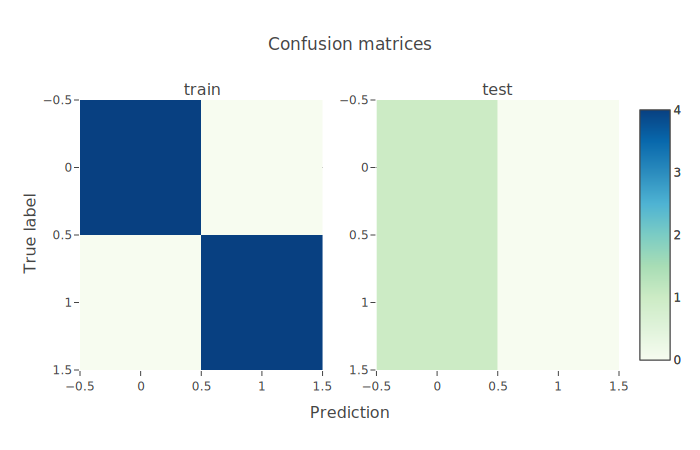

In [20]:
# Visualize confusion matrices
from plotly.subplots import make_subplots
cm_train = confusion_matrix(Y_train, Y_train_pred)
cm_test = confusion_matrix(Y_test, Y_test_pred)

fig = make_subplots(rows = 1, cols = 2, subplot_titles = ("train", "test"), 
                    x_title = 'Prediction', y_title = 'True label')
fig.update_layout(
        title = go.layout.Title(text = "Confusion matrices", x = 0.5))
fig.update_yaxes(autorange='reversed')
fig.add_trace(
    go.Heatmap(
        name = 'train',
        x = ['0', '1'], 
        y = ['0', '1'], 
        z = cm_train,
        colorscale = 'gnbu',
        zmin = 0,
        zmax = max(cm_train.max(), cm_test.max())
    ),
    row = 1,
    col = 1
)  
fig.add_trace(
    go.Heatmap(
        name = 'test',
        x = ['0', '1'], 
        y = ['0', '1'], 
        z = cm_test,
        colorscale = 'gnbu',
        zmin = 0,
        zmax = max(cm_train.max(), cm_test.max())
    ),
    row = 1,
    col = 2
)

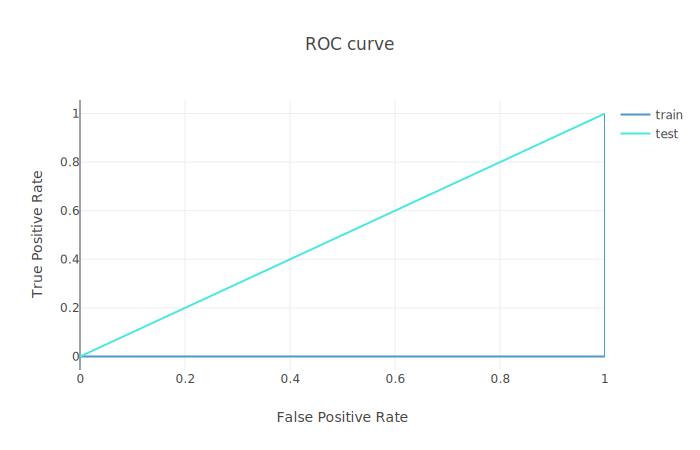

In [21]:
# Visualize ROC curves
probas_train = gridsearch.predict_proba(X_train)[:,1]
precisions, recalls, thresholds = roc_curve(Y_train, probas_train)
fig = go.Figure(
    data = go.Scatter(
        name = 'train',
        x = recalls, 
        y = precisions, 
        mode = 'lines'
    ),
    layout = go.Layout(
        title = go.layout.Title(text = "ROC curve", x = 0.5),
        xaxis = go.layout.XAxis(title = 'False Positive Rate'),
        yaxis = go.layout.YAxis(title = 'True Positive Rate')
    )
)

probas_test = gridsearch.predict_proba(X_test)[:,1]
precisions, recalls, thresholds = roc_curve(Y_test, probas_test)
fig.add_trace(go.Scatter(
    name = 'test',
    x = recalls, 
    y = precisions, 
    mode = 'lines'
    )
)
fig.show()